# Bracketing

This is a technique to determine the local minimum within an interval. In the event a derivative does not exist, this type of technique works.

## Utility Functions

Below will setup a viewable plotting function.

In [1]:
using Plots 

function plot_f(f, x, int_x, int_y)
    y = f.(x)
    plot(x, y)
    
    n_pts = length(int_x)
    c = distinguishable_colors(n_pts)
    for i in 1:n_pts
        l = Char(Int('a') + i - 1)
        scatter!([int_x[i]], [int_y[i]], c=c[i], label=l)
    end
end

plot_f (generic function with 1 method)

## Types of Bracketing

Let's start with a simple univariate bracketing method to find the local minimum. The univarite function must be convex, if it is not this method will not work (i.e., $e^x$ will fail).

1. **bracket_univariate_minimum**
    1. Inputs: a function, starting x position 0, s step size, and k expansion factor. 
    1. Outputs: a bracket interval [a,c]

In [2]:
function bracket_univariate_minimum(f, x=0., s=1e-2, k=2.0)
    # bracket upate
    bracket_update(a, s) = [a + s, f(a + s)]
    
    # setup initial interval
    a, ya = bracket_update(x, 0)
    b, yb = bracket_update(a, s)
    
    # if b is greater than a, swap variables, and change sign of step size
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s *= -1
    end
    
    c, yc = 0, 0
    anim = @animate for i in 1:100
        c, yc = bracket_update(b, s)
        
        plot_f(f, range(-5, 5, 100), [a, b, c], [ya, yb, yc])
    
        if yc > yb
            break
        end
        a, ya, b, yb = b, yb, c, yc
        s *= k
    end
    return a > c ? (c, a) : (a, c), anim
end

bracket_univariate_minimum (generic function with 4 methods)

In [3]:
f(x) = sin(x)

f (generic function with 1 method)

In [4]:
interval, anim = bracket_univariate_minimum(f)
println("Bracket minimum search", interval)

Bracket minimum search(-2.55, -0.6300000000000001)


[ Info: Saved animation to /Users/dakre/work/JuliaOptiMize/tmp.gif


Plots.AnimatedGif("/Users/dakre/work/JuliaOptiMize/tmp.gif")
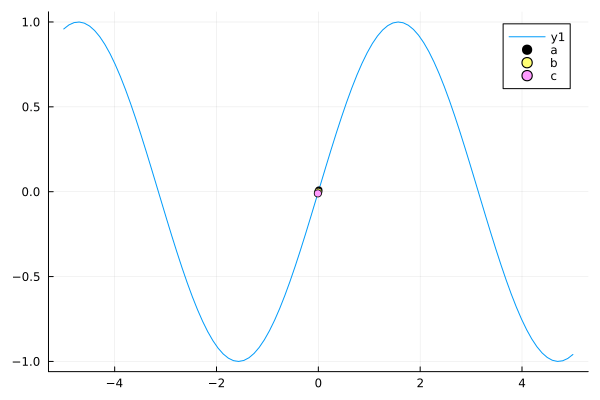

In [5]:
gif(anim, fps = 4)

2. **Fibonnaci Search**
    1. In this type of search we essentially recursively call into fibonacci sequence to solve the problem breaking it into sub problems to be solved (this breaks the interval down by a third each step). 
    $$
F_n
= 
\begin{cases}
1 \text{ if } n <= 2\\
F_{n-1} + F_{n-2} \text{ otherwise }
\end{cases}
$$
    2. Alternatively you can solve the fibonacci search by utilizing *binet's formula*
        
        $F_n = (Φ^n - (1 - Φ)^n) / √(5)$ where $Φ = (1 + √(5)) / 2 = 1.61803$ which is the *golden ratio*
        
        $s = F_n / F_{n-1} = (1 - √(5)) / (1 + √(5)) = -0.382$ where s is the ratio beween current and prior fibonacci values

In [6]:
function fibonacci_search(func, a, b, n)
    # Calculate the Fibonacci sequence up to n terms
    fib = [0, 1]
    for i in 3:n
        push!(fib, fib[end] + fib[end-1])
    end
    
    update_x1(a, b, i) = a + (b - a) * (fib[i - 2] / fib[i])
    update_x2(a, b, i) = a + (b - a) * (fib[i - 1] / fib[i])
    
    # Define search points within the interval
    x1 = update_x1(a, b, n)
    x2 = update_x2(a, b, n)
    
    println("Initial ratios ", (fib[n - 2] / fib[n]), " ", (fib[n - 1] / fib[n]))
    
    f1 = func(x1)
    f2 = func(x2)
    
    rng = range(a, b, 100)

    anim = @animate for i in n-1:-1:3
        plot_f(func, rng, [x1, x2], [f1, f2])
        
        if f1 < f2
            b, x2, f2 = x2, x1, f1
            x1 = update_x1(a, b, i)
            f1 = func(x1)
        else
            a, x1, f1 = x1, x2, f2
            x2 = update_x2(a, b, i)
            f2 = func(x2)
        end
    end

    # Final step with only two remaining points
    x3 = (a + b) / 2
    f3 = func(x3)

    return f1 < f1 ? (x1, f1) : (x2, f2), anim
end

fibonacci_search (generic function with 1 method)

In [7]:
f(x) = x^2 + 5x + 6

(min_x, min_value), anim = fibonacci_search(f, -10., 10., 10)
println("Minimum at x = $min_x, f(x) = $min_value")

Initial ratios 0.38235294117647056 0.6176470588235294
Minimum at x = -2.3529411764705888, f(x) = -0.22837370242214572


[ Info: Saved animation to /Users/dakre/work/JuliaOptiMize/tmp.gif


Plots.AnimatedGif("/Users/dakre/work/JuliaOptiMize/tmp.gif")
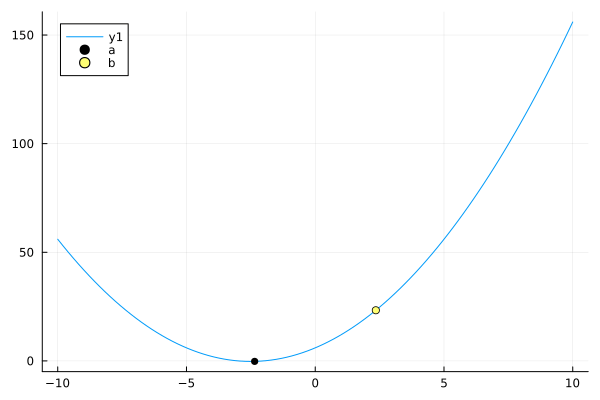

In [8]:
gif(anim, fps = 4)

3. **Golden Search**
    1. Instead of generating a fibonacci sequence and then solve the search to n; lets solve using the golden ratio directly.

In [9]:
φ = Base.MathConstants.golden

function golden_search(func, a, b, n)    
    ρ = φ - 1 # φ defined as the golden ratio in Julia

    update_bracket(a, b) = ρ * a + (1 - ρ) * b
    
    d = update_bracket(b, a)
    yd = func(d)
    
    rng = range(a, b, 100)
    
    anim = @animate for i in 1:n-1
        c = update_bracket(a, b)
        yc = func(c)
        
        plot_f(func, rng, [a, b], [yc, yd])
        
        if yc < yd
            b, d, yd = d, c, yc
        else
            a, b = b, c
        end
    end
    
    return a < b ? (a, b) : (b, a), anim
end

golden_search (generic function with 1 method)

In [10]:
f(x) = x^2 + sin(x)^3 / x

interval, anim = golden_search(f, -10., 10., 10)
println("Golden search interval ", interval)

Golden search interval (-0.13155617496424915, 0.1315561749642482)


[ Info: Saved animation to /Users/dakre/work/JuliaOptiMize/tmp.gif


Plots.AnimatedGif("/Users/dakre/work/JuliaOptiMize/tmp.gif")
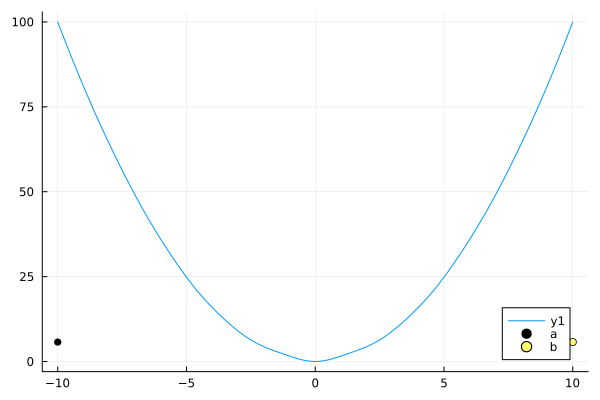

In [11]:
gif(anim, fps = 4)

4. **Quadratic Fit**
    1. In this type of search we seek solve a convex function via iterative fitting of a quadratic function. Following the similar fashion as before with bracketing, use three variables $x_1, x_2, x_3$ and then find the coefficients $a < b < c$ that go through points $(x_1, y_1), (x_2, y_2), (x_3, y_3)$
    
        $q(x) = a + b*x + c*x^2$

        $y_1 = a + x_1*b + x_1*c^2$

        $y_2 = a + x_2*b + x_2*c^2$

        $y_3 = a + x_3*b + x_3*c^2$
        
    2. Setup a matrix describing these systems of equations

    \begin{equation}
    [y_1, y_2, y_3] = 
    \begin{pmatrix}
      1 & x_1 & x_1^2 \\
      1 & x_2 & x_2^2 \\
      1 & x_3 & x_3^2 
    \end{pmatrix}
    \begin{pmatrix}
    a \\ b \\ c
    \end{pmatrix}
    \end{equation}

    3. To solve for the coefficients $p_1, p_2, p_3$ we'll have to invert the matrix (thus we need to enforce positive semidefinite on the points a, b, c)
    
     \begin{equation}
    [a, b, c] = 
    \begin{pmatrix}
      1 & x_1 & x_1^2 \\
      1 & x_2 & x_2^2 \\
      1 & x_3 & x_3^2 
    \end{pmatrix}^{-1}
    \begin{pmatrix}
    y_1 \\ y_2 \\ y_3
    \end{pmatrix}
    \end{equation}   

In [12]:
function quadratic_fit_search(func, a, c, n; ρ = φ - 1)
    x1, x3 = a, c
    x_min, y_min = 0, 0
    rng = range(a, c, 100)
    
    update_bracket(u, v) = ρ * u + (1 - ρ) * v
    
    anim = @animate for i in 1:n
        x2 = (a + c) / 2
        
        y1, y2, y3 = func(x1), func(x2), func(x3)
        
        A = [1 x1 x1^2; 1 x2 x2^2; 1 x3 x3^2]
        B = [y1; y2; y3]
        
        X = A \ B # inverse divide operation
        
        a, b, c = X
        
        # f = a + bx + cx^2
        # df/dx = 0 -> 0 = b + 2cx 
        # -2cx = b -> x = -b / 2c
        
        x_min = -b / (2*c) # locate vertex describinig minimum
        y_min = func(x_min)
        
        plot_f(func, rng, [x_min], [y_min])
        
        # true case:
        # - evaluate output to midpoint, if it's less than midpoint take
        # the lower of the x inputs which drove the midpoint output to be less 
        # than y2
        # false case:
        # - move in the opposite direction since y_min was greater than y2
        if y_min < y2
            if x_min < x2
                x3 = update_bracket(x2, x3) # move left (x3 <- x2)
            else
                x1 = update_bracket(x2, x1) # move right (x1 <- x2)
                #x1 = x2 # move right
            end
        else
            if x_min < x2
                x1 = update_bracket(x_min, x1) # move right (x1 <- x_min)
            else
                x3 = update_bracket(x_min, x3) # move left (x3 <- x_min)
            end
        end
    end
    
    return x_min, y_min, anim
end

quadratic_fit_search (generic function with 1 method)

In [13]:
f(x) = cos(x)^2 + 2

x_min, y_min, anim = quadratic_fit_search(f, -10., 10., 10)
println("Quadratic search minimum ", x_min, " ", y_min)

Quadratic search minimum 1.5241246455071333 2.0021766647085277


[ Info: Saved animation to /Users/dakre/work/JuliaOptiMize/tmp.gif


Plots.AnimatedGif("/Users/dakre/work/JuliaOptiMize/tmp.gif")
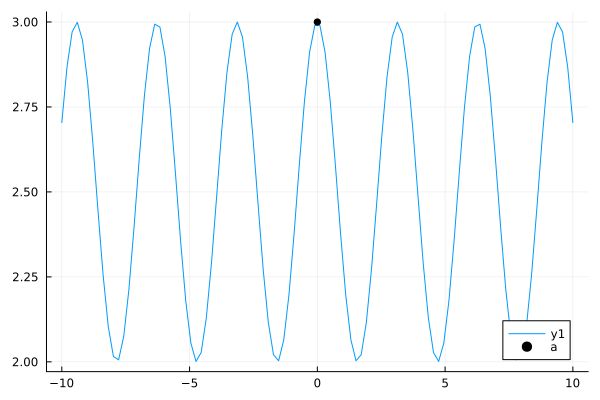

In [14]:
gif(anim, fps = 4) # todo some overshooting occuring pending on function

5. **Shubert-Piyavaskii Method**
    1. Midpoint sampling
        1. In this function we iteratively sample the midpoint of a bounds $[a, b]$ by taking the midpoint $(a + b) / 2$
        2. We then construct a lower bounds function based on the Lipshitz constant $l$ where this describe the slope of a line intersecting with the midpoint-- $f(x_0) - l(x - x_0)$ for x > x_0 and $f(x_1) + l(x + x_0)$ for x < x_0
        3. Update uncetainty interval $[x^i - 1/l * (y_min - y^i), x^i + 1/l * (y_min + y^i)]$
        4. Repeat (1) through (3) until convergence is met (typically minimum falling within a threshold defined by ε)

In [15]:
# TODO code

6. **Bisection Method**
    1. This method is used to find roots of a function by taking the function $f(x)$ and evaluating the derivative at zero $f'(x) = 0$ which determines a local minimum
    2. The function requires a bracket [a,b] where a root is known to exist
    3. Main intuition here is if $f(a)$ sign not equal to $f(b)$ then a root is guaranteed to exist
    4. Convergence guarantee on $ln(|a - b| / ε)$
    5. a & b must be on opposite side of zero 

In [16]:
# TODO code